In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results





# Calculate the date 1 year ago from the last data point in the database
engine.execute('''select m.date, prcp
from measurement m
inner join station s on s.station = m.station
order by m.date desc
limit 1''').fetchall()

[('2017-08-23', 0.0)]

<function matplotlib.pyplot.show(*args, **kw)>

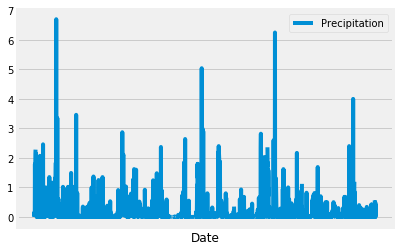

In [24]:
# Perform a query to retrieve the data and precipitation scores
precipdata = engine.execute('''select date(m.date), prcp
from measurement m
inner join station s on s.station = m.station
where m.date >= date('2016-08-23')
order by m.date
''').fetchall()
precipdf = pd.DataFrame(precipdata)
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipdf.columns = ['Date','Precipitation']
precipdf.set_index('Date').sort_values('Date')
precipdf.head(200)


# Use Pandas Plotting with Matplotlib to plot the data
precipdf.plot()
plt.xlabel("Date")
plt.xticks([])
plt.show

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipdf.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
engine.execute('''select count(distinct station) from measurement''').fetchall()

[(9,)]

In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = engine.execute('''select m.station, count(m.station) as count
from measurement m
inner join station s on s.station = m.station
group by m.station
order by count desc''').fetchall()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [40]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = stations[0][0]
most_active

active_data = engine.execute(f'''select min(tobs), max(tobs), avg(tobs)
from measurement m
inner join station s on s.station = m.station
where m.station = "{most_active}"
''').fetchall()

active_data

[(54.0, 85.0, 71.66378066378067)]

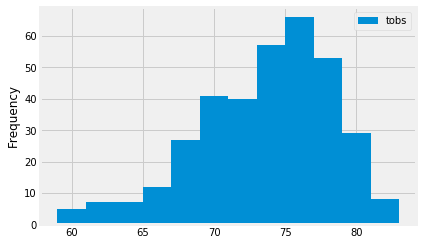

In [79]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempdata = engine.execute(f'''select tobs, count(m.tobs) as count
from measurement m
inner join station s on s.station = m.station
where 1=1 and
    m.date >= date('2016-08-23') and
    m.station = "{most_active}"
group by m.tobs
''').fetchall()
tempdf = pd.DataFrame(tempdata)
tempdf.columns = ['Temp','tobs']
tempdf.head()

plt.hist(tempdf['Temp'],bins=12,weights=tempdf['tobs'])
plt.ylabel("Frequency")
plt.legend(['tobs'],loc='best')
plt.show()

In [92]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [116]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
triptemp = calc_temps('2016-09-07', '2016-09-21')
triptemp

[(70.0, 77.18947368421053, 83.0)]

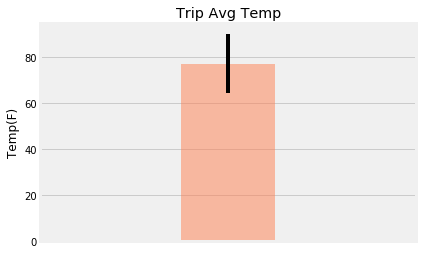

In [117]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak = abs((triptemp[0][0]) - (triptemp[0][2]))

plt.bar(x=1,width=0.5,height = triptemp[0][1], bottom=None, yerr=peak, color="coral",alpha=0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.xticks([])
plt.xlim(0,2)
plt.tight_layout
plt.show()


In [120]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_precip(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return engine.execute(f'''select m.station, s.name,s.latitude,s.longitude,s.elevation,sum(m.prcp) as totalprecip
from measurement m
inner join station s on s.station = m.station
where 1=1 and
    date >= date({start_date}") and
    date <= date("{end_date}")
group by m.station''')

calc_precip('2012-02-28', '2012-03-05')

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
